In [1]:
import uproot
import numpy as np
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import itertools
import awkward as ak
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
file = uproot.open("tracking_losses_ntuple_Bd2KstEE.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1")
#file = uproot.open("tracking_losses_ntuple_Dst0ToD0EE.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1")


#selektiere nur elektronen von B->K*ee und nur solche mit einem momentum von ueber 5 GeV 
allcolumns = file.arrays()
found = allcolumns[(allcolumns.isElectron) & (~allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p > 5e3)] #B: 9056
lost = allcolumns[(allcolumns.isElectron) & (allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p > 5e3)] #B: 1466

ak.num(found, axis=0)
#ak.count(found, axis=None)


9056

In [3]:
def t_eff(found, lost, axis = 0):
    sel = ak.num(found, axis=axis)
    des = ak.num(lost, axis=axis)
    return sel/(sel + des)

t_eff(found, lost)

0.8606728758791105

In [4]:
#finden wir die elektronen die keine bremsstrahlung gemacht haben mit hoher effizienz?
#von energie der photonen abmachen
#scan ab welcher energie der photonen die effizienz abfällt

#abhängigkeit vom ort der emission untersuchen   <- noch nicht gemacht



#idea: we make an event cut st all events that contain a photon of energy > cutoff_energy are not included
"""
ph_e = found["brem_photons_pe"]
event_cut = ak.all(ph_e<cutoff_energy,axis=1)
ph_e = ph_e[event_cut]
"""



for cutoff_energy in range(0,1050,50):
	nobrem_f = found[ak.all(found["brem_photons_pe"]<cutoff_energy,axis=1)]
	nobrem_l = lost[ak.all(lost["brem_photons_pe"]<cutoff_energy,axis=1)]
	print("sample size: ",ak.num(nobrem_f,axis=0)+ak.num(nobrem_l,axis=0))
	print("eff (cutoff = ",str(cutoff_energy),") = ",str(t_eff(nobrem_f,nobrem_l)))

"""
we see that a cutoff energy of 350MeV is ideal because the efficiency drops significantly for higher values
"""
cutoff_energy = 350.0 #MeV

"""
better statistics: cutoff=350MeV - sample size: 150 events and efficiency=0.9533
"""
nobrem_found = found[ak.all(found["brem_photons_pe"]<cutoff_energy,axis=1)]
nobrem_lost = lost[ak.all(lost["brem_photons_pe"]<cutoff_energy,axis=1)]

print("\nsample size: ",ak.num(nobrem_found,axis=0)+ak.num(nobrem_lost,axis=0))
t_eff(nobrem_found, nobrem_lost)

sample size:  32
eff (cutoff =  0 ) =  0.96875
sample size:  32
eff (cutoff =  50 ) =  0.96875
sample size:  32
eff (cutoff =  100 ) =  0.96875
sample size:  43
eff (cutoff =  150 ) =  0.9767441860465116
sample size:  65
eff (cutoff =  200 ) =  0.9692307692307692
sample size:  97
eff (cutoff =  250 ) =  0.9587628865979382
sample size:  129
eff (cutoff =  300 ) =  0.9457364341085271
sample size:  150
eff (cutoff =  350 ) =  0.9533333333333334
sample size:  169
eff (cutoff =  400 ) =  0.9408284023668639
sample size:  197
eff (cutoff =  450 ) =  0.9390862944162437
sample size:  227
eff (cutoff =  500 ) =  0.920704845814978
sample size:  257
eff (cutoff =  550 ) =  0.9260700389105059
sample size:  297
eff (cutoff =  600 ) =  0.9326599326599326
sample size:  334
eff (cutoff =  650 ) =  0.9281437125748503
sample size:  366
eff (cutoff =  700 ) =  0.9289617486338798
sample size:  400
eff (cutoff =  750 ) =  0.925
sample size:  436
eff (cutoff =  800 ) =  0.9151376146788991
sample size:  468
e

0.9533333333333334

In [5]:
#hier wird ohne rücksicht auf energie der photonen getrennt

nobrem_found = found[found["brem_photons_pe_length"]==0]
nobrem_lost = lost[lost["brem_photons_pe_length"]==0]

"""
die effizienz mit der wir elektronen finden, die keine bremsstrahlung gemacht haben, ist gut mit 0.9688.
allerdings haben wir hier nur sehr wenige teilchen (<100)
"""
print(ak.num(nobrem_found,axis=0))
t_eff(nobrem_found, nobrem_lost)


31


0.96875

In [6]:
#wie viel energie relativ zur anfangsenergie verlieren die elektronen durch bremstrahlung und hat das einen einfluss darauf ob wir sie finden oder nicht?


In [7]:
#keine rücksicht auf energie der photonen
brem_found = found[found["brem_photons_pe_length"]!=0]
energy_found = ak.to_numpy(brem_found["energy"])
eph_found = ak.to_numpy(ak.sum(brem_found["brem_photons_pe"], axis=-1, keepdims=False))
energyloss_found = eph_found/energy_found


brem_lost = lost[lost["brem_photons_pe_length"]!=0]
energy_lost = ak.to_numpy(brem_lost["energy"])
eph_lost = ak.to_numpy(ak.sum(brem_lost["brem_photons_pe"], axis=-1, keepdims=False))
energyloss_lost = eph_lost/energy_lost

t_eff(brem_found,brem_lost)

0.8603431839847474

In [8]:
mean_energyloss_found = ak.mean(energyloss_found)
mean_energyloss_lost = ak.mean(energyloss_lost)
print("mean energyloss relative to initial energy (found): ", mean_energyloss_found)
print("mean energyloss relative to initial energy (lost): ", mean_energyloss_lost)

mean energyloss relative to initial energy (found):  0.6475128752780828
mean energyloss relative to initial energy (lost):  0.8241268441538472


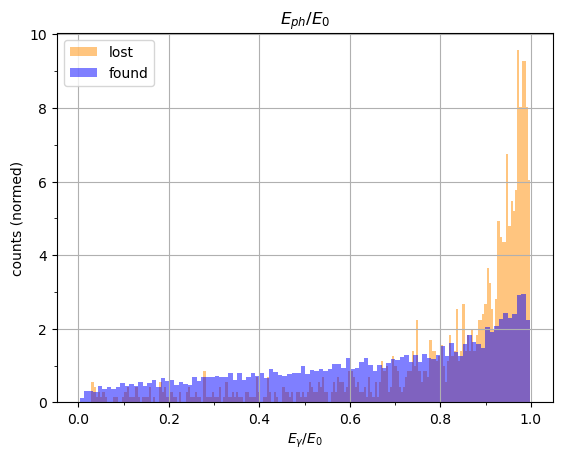

In [9]:
#in abhängigkeit von der energie der elektronen

plt.hist(energyloss_lost, bins=200, density=True, alpha=0.5, histtype='bar', color="darkorange", label="lost")
plt.hist(energyloss_found, bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label="found")
plt.xticks(np.arange(0,1.1,0.1), minor=True,)
plt.yticks(np.arange(0,10,1), minor=True)
plt.xlabel(r"$E_\gamma/E_0$")
plt.ylabel("counts (normed)")
plt.title(r'$E_{ph}/E_0$')
plt.legend()
plt.grid()

"""
found: elektronen verlieren durchschnittlich 0.65 ihrer anfangsenergie durch bremsstrahlung
lost: elektronen verlieren durchschnittlich 0.82 ihrer anfangsenergie durch bremsstrahlung

-> wir können sofort erkennen, dass verlorene elektronen im schnitt mehr energie durch bremsstrahlung verlieren als gefundene, 
aber auch die rate der gefundenen elektronen steigt für raten nahe 1, wenn auch wesentlich schwächer als für verlorene elektronen.
die meisten verlorenen elektronen verlieren >0.8 ihrer anfangsenergie.
"""

plt.show()

In [10]:
#ist die shape der teilspur im scifi anders? (koenntest du zum beispiel durch vergleich der verteilungen der fit parameter studieren,
#in meiner thesis findest du das fitmodell -- ist einfach ein polynom dritten grades)
z_ref=8520 #mm

def scifi_track(z, a, b, c, d):
    return a + b*(z-z_ref) + c*(z-z_ref)**2 + d*(z-z_ref)**3

def z_mag(xv, zv, tx, a, b):
    """ optical centre of the magnet is defined as the intersection between the trajectory tangents before and after the magnet

    Args:
        xv (double): velo x track
        zv (double): velo z track
        tx (double): velo x slope
        a (double): ax parameter of track fit
        b (double): bx parameter of track fit

    Returns:
        double: z_mag
    """
    return (xv-tx*zv-a+b*z_ref)/(b-tx)

In [11]:
scifi_found = found[found["scifi_hit_pos_x_length"]>3]
scifi_lost = lost[lost["scifi_hit_pos_x_length"]>3]
#should be fulfilled by all candidates

scifi_x_found = scifi_found["scifi_hit_pos_x"]
scifi_z_found = scifi_found["scifi_hit_pos_z"]

tx_found = scifi_found["velo_track_tx"]

scifi_x_lost = scifi_lost["scifi_hit_pos_x"]
scifi_z_lost = scifi_lost["scifi_hit_pos_z"]

tx_lost = scifi_lost["velo_track_tx"]

xv_found = scifi_found["velo_track_x"]
zv_found = scifi_found["velo_track_z"]

xv_lost = scifi_lost["velo_track_x"]
zv_lost = scifi_lost["velo_track_z"]



#ak.num(scifi_found["energy"], axis=0)
#scifi_found.snapshot()

In [12]:
#tx_lost.show()

In [13]:
scifi_fitpars_found = ak.ArrayBuilder()

for i in range(0,ak.num(scifi_found["energy"], axis=0)):
    popt, pcov = curve_fit(scifi_track,ak.to_numpy(scifi_z_found[i,:]),ak.to_numpy(scifi_x_found[i,:]))
    scifi_fitpars_found.begin_list()
    scifi_fitpars_found.real(popt[0])
    scifi_fitpars_found.real(popt[1])
    scifi_fitpars_found.real(popt[2])
    scifi_fitpars_found.real(popt[3])
    scifi_fitpars_found.end_list()

scifi_fitpars_lost = ak.ArrayBuilder()

for i in range(0,ak.num(scifi_lost["energy"], axis=0)):
    popt, pcov = curve_fit(scifi_track,ak.to_numpy(scifi_z_lost[i,:]),ak.to_numpy(scifi_x_lost[i,:]))
    scifi_fitpars_lost.begin_list()
    scifi_fitpars_lost.real(popt[0])
    scifi_fitpars_lost.real(popt[1])
    scifi_fitpars_lost.real(popt[2])
    scifi_fitpars_lost.real(popt[3])
    scifi_fitpars_lost.end_list()


scifi_fitpars_lost = scifi_fitpars_lost.to_numpy()
scifi_fitpars_found = scifi_fitpars_found.to_numpy()



dtx_found = scifi_fitpars_found[:,1] - tx_found
dtx_lost = scifi_fitpars_lost[:,1] - tx_lost


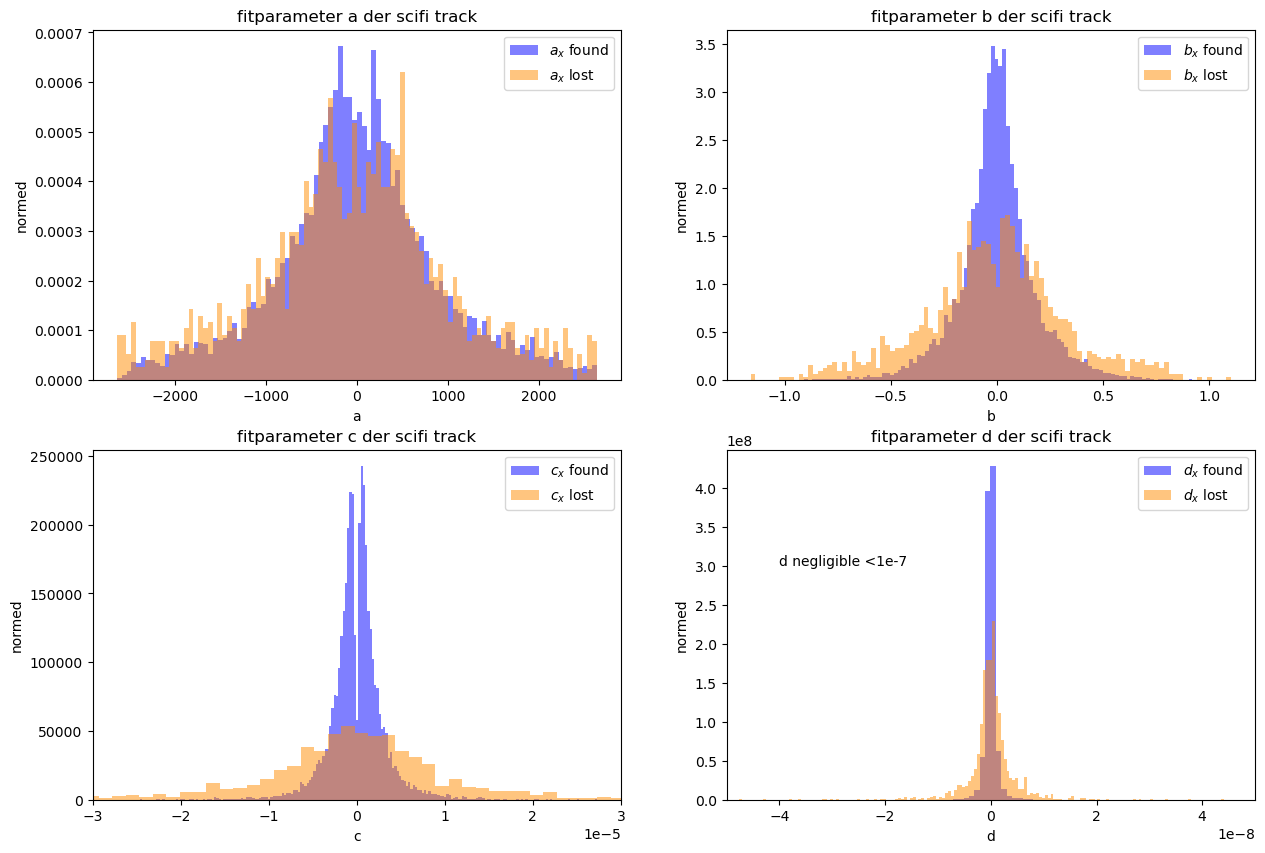

In [14]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

ax0.hist(scifi_fitpars_found[:,0], bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$a_x$ found")
ax0.hist(scifi_fitpars_lost[:,0], bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$a_x$ lost")
ax0.set_xlabel("a")
ax0.set_ylabel("normed")
ax0.set_title("fitparameter a der scifi track")
ax0.legend()

ax1.hist(scifi_fitpars_found[:,1], bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$b_x$ found")
ax1.hist(scifi_fitpars_lost[:,1], bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$b_x$ lost")
ax1.set_xlabel("b")
ax1.set_ylabel("normed")
ax1.set_title("fitparameter b der scifi track")
ax1.legend()
#evtl multiple scattering candidates (lost); findet man einen gewissen endvtx_type (mult scattering)
#steiler velo winkel (eta)? vertex type? evtl bremsstrahlung?


ax2.hist(scifi_fitpars_found[:,2], bins=500, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$c_x$ found")
ax2.hist(scifi_fitpars_lost[:,2], bins=500, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$c_x$ lost")
ax2.set_xlim([-3e-5,3e-5])
ax2.set_xticks(np.arange(-3e-5,3.5e-5,1e-5),minor=False)
ax2.set_xlabel("c")
ax2.set_ylabel("normed")
ax2.set_title("fitparameter c der scifi track")
ax2.legend()

ax3.hist(scifi_fitpars_found[:,3], bins=500, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$d_x$ found")
ax3.hist(scifi_fitpars_lost[:,3], bins=500, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$d_x$ lost")
ax3.set(xlim=(-5e-8,5e-8))
ax3.text(-4e-8,3e8,"d negligible <1e-7")
ax3.set_xlabel("d")
ax3.set_ylabel("normed")
ax3.set_title("fitparameter d der scifi track")
ax3.legend()

"""
a_x: virtual hit on the reference plane
"""

plt.show()

In [15]:
print("found")
print("a = ", str(np.mean(scifi_fitpars_found[:,0])))
print("b = ", str(np.mean(scifi_fitpars_found[:,1])))
print("c = ", str(np.mean(scifi_fitpars_found[:,2])))
print("d = ", str(np.mean(scifi_fitpars_found[:,3])))

print("lost")
print("a = ", str(np.mean(scifi_fitpars_lost[:,0])))
print("b = ", str(np.mean(scifi_fitpars_lost[:,1])))
print("c = ", str(np.mean(scifi_fitpars_lost[:,2])))
print("d = ", str(np.mean(scifi_fitpars_lost[:,3])))

found
a =  -0.6718207391527037
b =  0.0013778237292529144
c =  3.3126998287416195e-08
d =  -1.0330674442255529e-10
lost
a =  -36.98764338200992
b =  -0.015685137956233643
c =  -8.265859479503501e-07
d =  -1.541510766903436e-11


In [16]:
np.min(scifi_fitpars_found[:,3])

-4.6785491318157854e-07

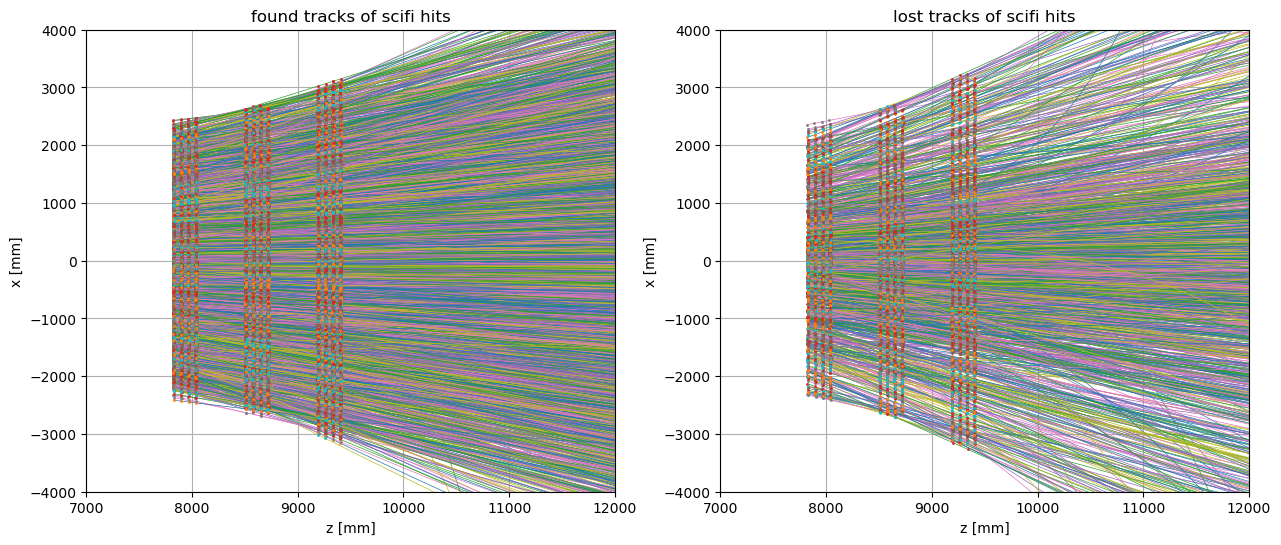

In [17]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

for i in range(0,ak.num(scifi_found["energy"], axis=0)):
    z_coord = np.linspace(scifi_z_found[i,0],12000,300)
    fit = scifi_track(z_coord, *scifi_fitpars_found[i])
    ax0.plot(z_coord, fit, "-", lw=0.5)
    ax0.errorbar(ak.to_numpy(scifi_z_found[i,:]),ak.to_numpy(scifi_x_found[i,:]),fmt=".",ms=2)

#ax0.legend()
ax0.set_xlabel("z [mm]")
ax0.set_ylabel("x [mm]")
ax0.set_title("found tracks of scifi hits")
ax0.set(xlim=(7e3,12000), ylim=(-4000,4000))
ax0.grid()

for i in range(0,ak.num(scifi_lost["energy"], axis=0)):
    z_coord = np.linspace(scifi_z_lost[i,0],12000,300)
    fit = scifi_track(z_coord, *scifi_fitpars_lost[i])
    ax1.plot(z_coord, fit, "-", lw=0.5)
    ax1.errorbar(ak.to_numpy(scifi_z_lost[i,:]),ak.to_numpy(scifi_x_lost[i,:]),fmt=".",ms=2)

#ax1.legend()
ax1.set_xlabel("z [mm]")
ax1.set_ylabel("x [mm]")
ax1.set_title("lost tracks of scifi hits")
ax1.set(xlim=(7e3,12000), ylim=(-4000,4000))
ax1.grid()

plt.show()

In [18]:
#vergleich der zmag werte
zmag_found = z_mag(xv_found, zv_found, tx_found, scifi_fitpars_found[:,0], scifi_fitpars_found[:,1])
zmag_lost = z_mag(xv_lost, zv_lost, tx_lost, scifi_fitpars_lost[:,0], scifi_fitpars_lost[:,1])
zmag_lost = zmag_lost[~np.isnan(zmag_lost)]
zmag_found = zmag_found[~np.isnan(zmag_found)]

print("found \nzmag = ", str(np.mean(zmag_found)))
print("lost \nzmag = ", str(np.mean(zmag_lost)))

found 
zmag =  5215.5640412342
lost 
zmag =  5450.484726770035


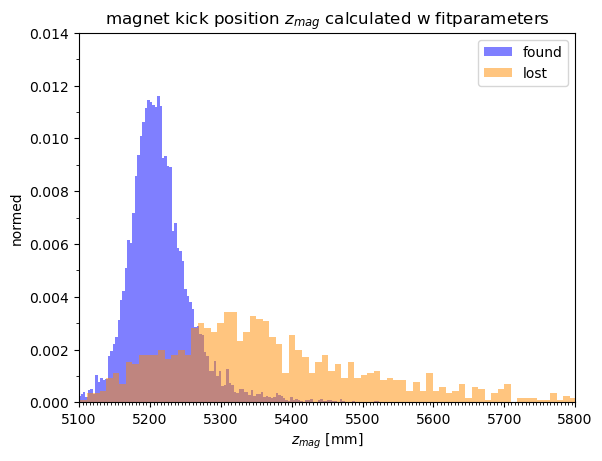

In [19]:
plt.hist(zmag_found, bins=5000, density=True, alpha=0.5, histtype='bar', color="blue", label="found")
plt.hist(zmag_lost, bins=300, density=True, alpha=0.5, histtype="bar",color="darkorange", label="lost")
plt.xlabel("$z_{mag}$ [mm]")
plt.ylabel("normed")
plt.title("magnet kick position $z_{mag}$ calculated w fitparameters")
plt.legend()
plt.xticks(np.arange(5100,5800,5), minor=True)
plt.yticks(np.arange(0,0.015,0.001), minor=True)
plt.xlim(5100,5800)

"""
wir können einen radikalen unterschied für den z_mag wert erkennen, zwischen den found and lost elektronen.
"""

plt.show()

In [20]:

file.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
all_endvtx_types_... | int32_t                  | AsDtype('>i4')
all_endvtx_types     | float[]                  | AsJagged(AsDtype('>f4'))
all_endvtx_x_length  | int32_t                  | AsDtype('>i4')
all_endvtx_x         | float[]                  | AsJagged(AsDtype('>f4'))
all_endvtx_y_length  | int32_t                  | AsDtype('>i4')
all_endvtx_y         | float[]                  | AsJagged(AsDtype('>f4'))
all_endvtx_z_length  | int32_t                  | AsDtype('>i4')
all_endvtx_z         | float[]                  | AsJagged(AsDtype('>f4'))
brem_photons_pe_l... | int32_t                  | AsDtype('>i4')
brem_photons_pe      | float[]                  | AsJagged(AsDtype('>f4'))
brem_photons_px_l... | int32_t                  | AsDtype('>i4')
brem_photons_px      | float[]                  | AsJagged(AsDtype('>f4')